# 核支持向量机
核支持向量机（通常简称为SVM）是可以推广到更复杂模型的扩展，这些模型无法被输入空间的超平面定义。向量机可以同时用于分类和回归。

In [1]:
import sys
print("Python version:{}".format(sys.version))

import pandas as pd
print("pandas version:{}".format(pd.__version__))

import matplotlib
print("matplotlib version:{}".format(matplotlib.__version__))
import matplotlib.pyplot as plt

import numpy as np
print("Numpy version:{}".format(np.__version__))

import scipy as sp
print("Scipy version:{}".format(sp.__version__))

import IPython
print("IPython version:{}".format(IPython.__version__))

import sklearn
print("scikit-learn version:{}".format(sklearn.__version__))

import mglearn
import graphviz

Python version:3.7.1 (default, Dec 10 2018, 22:54:23) [MSC v.1915 64 bit (AMD64)]
pandas version:0.23.4
matplotlib version:3.0.2
Numpy version:1.15.4
Scipy version:1.1.0
IPython version:7.2.0
scikit-learn version:0.20.1


# 线性模型与非线性验证
线性模型在低维空间中可能非常受限，因为线和平面的灵活性有限。有一种方法可以让线性模型更加灵活，就是添加更多的特征——举个例子，添加输入特征的交互项或多项式。

Text(0, 0.5, 'Feaature 1')

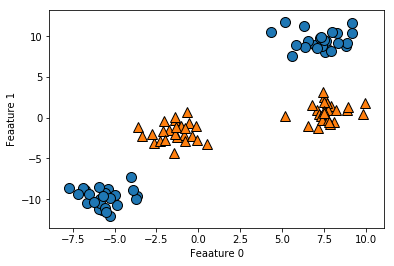

In [2]:
from sklearn.datasets import make_blobs
X,y=make_blobs(centers=4,random_state=8)

y=y%2

mglearn.discrete_scatter(X[:,0],X[:,1],y)
plt.xlabel("Feaature 0")
plt.ylabel("Feaature 1")

用于分类的线性模型只能用一条直线来划分数据点，对这个数据集无法给出较好的结果：

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Text(0, 0.5, 'Feaature 1')

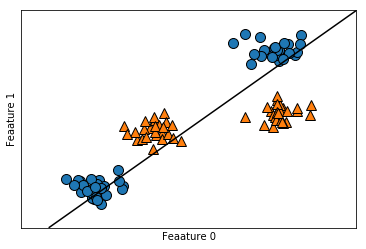

In [4]:
from sklearn.svm import LinearSVC

linear_svm=LinearSVC().fit(X,y)

mglearn.plots.plot_2d_separator(linear_svm,X)
mglearn.discrete_scatter(X[:,0],X[:,1],y)
plt.xlabel("Feaature 0")
plt.ylabel("Feaature 1")

现在我们对输入特征进行扩展，比如说添加第二个特征的平方（feature1 ** 2）作为一个新特征，现在我们将每个数据点表示为三维点（feature0,feature1,feature1 ** 2）,而不是二维点（feature0,feature1）。我们将这个心的表示画出三维散点图：

Text(0.5, 0, 'feature1**2')

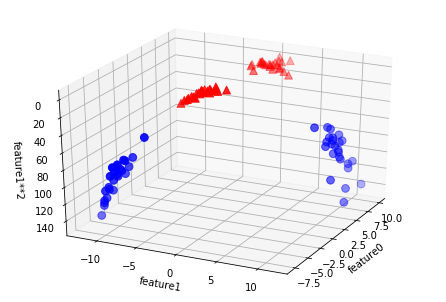

In [3]:
X_new=np.hstack([X,X[:,1:]**2])

from mpl_toolkits.mplot3d import Axes3D,axes3d
figure=plt.figure()
# 3D可视化
ax=Axes3D(figure,elev=-152,azim=-26)
# 首先画出所有y==0的点，然后画出所有y==1的点
mask= y==0
ax.scatter(X_new[mask,0],X_new[mask,1],X_new[mask,2],c='b',cmap=mglearn.cm2,s=60)
ax.scatter(X_new[~mask,0],X_new[~mask,1],X_new[~mask,2],c='r',marker='^',cmap=mglearn.cm2,s=60)
ax.set_xlabel("feature0")
ax.set_ylabel("feature1")
ax.set_zlabel("feature1**2")

在数据的新表示中，现在可以用线性模型（三维空间中的平面）将这两个类别分开。我们可以用线性模型拟合扩展后的数据来验证这一点：